### Imports

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import random
import sys
import os 

import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from tqdm import tqdm
from copy import deepcopy

In [4]:
DATA_ROOT = '/group/jug/federico/careamics_training/data'
OUT_ROOT = '/group/jug/federico/careamics_training/training'
CODE_ROOT = '/home/federico.carrara/'
DEBUG = False

In [52]:
sys.path.append(os.path.join(CODE_ROOT, 'Documents/projects/careamics/src'))

from careamics.train_lvae import create_dataset
from careamics.models.lvae.utils import (
    ModelType, LossType
)
from careamics.models.lvae import get_config
from careamics.models.lvae.data_utils import DataType, DataSplitType, GridAlignement, load_tiff
from careamics.models.lvae.metrics import (
    PSNR, 
    RangeInvariantPsnr,
    avg_psnr,
    avg_range_inv_psnr,
    avg_ssim,
    compute_masked_psnr,
    compute_multiscale_ssim
)
from careamics.models.lvae.train_utils import get_mean_std_dict_for_model
from careamics.models.lvae.lightning_module import LadderVAELight
from careamics.models.lvae.eval_utils import (
    show_for_one, 
    get_plots_output_dir,
    get_dset_predictions,
    stitch_predictions,
    Calibration,
    get_calibrated_factor_for_stdev,
    plot_calibration,
    clean_ax,
    plot_error
)
# from disentangle.analysis.lvae_utils import get_img_from_forward_output
# from disentangle.analysis.plot_utils import get_k_largest_indices,plot_imgs_from_idx
# from disentangle.analysis.critic_notebook_utils import get_mmse_dict, get_label_separated_loss
# from disentangle.sampler.random_sampler import RandomSampler

torch.multiprocessing.set_sharing_strategy('file_system')

In [6]:
def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

In [7]:
ckpt_dir = os.path.join(OUT_ROOT, '2406/LVAE_denoiSplit/45')
assert os.path.exists(ckpt_dir)

In [8]:
# def get_dtype(ckpt_fpath):
#     if os.path.isdir(ckpt_fpath):
#         ckpt_fpath = ckpt_fpath[:-1] if ckpt_fpath[-1] == '/' else ckpt_fpath
#     elif os.path.isfile(ckpt_fpath):
#         ckpt_fpath = os.path.dirname(ckpt_fpath)
#     assert ckpt_fpath[-1] != '/'
#     return int(ckpt_fpath.split('/')[-2].split('-')[0][1:])

In [9]:
# dtype = get_dtype(ckpt_dir)

### Set Evaluation Parameters

In [10]:
# Set parameters
image_size_for_grid_centers = 32
mmse_count = 10
custom_image_size = None
data_t_list = None #[0]
model_type = ModelType.LadderVae
save_comparative_plots =False
enable_calibration = True
batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False # inspect training performance
eval_datasplit_type = DataSplitType.Val    
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

### Load config 

In [11]:
def get_model_checkpoint(ckpt_dir, mode='best'):
    output = []
    if mode == 'best':
        for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
            output.append(filename)
    elif mode == 'last':
        for filename in glob.glob(ckpt_dir + "/*_last.ckpt"):
            output.append(filename)
    else:
        raise ValueError(f"Mode can be either 'best' or 'last', while you selected {mode}.")
    assert len(output) == 1, '\n'.join(output)
    return output[0]

In [12]:
def load_config(config_fpath):
    if os.path.isdir(config_fpath):
        config_fpath = os.path.join(config_fpath, 'config.pkl')
    else:
        assert config_fpath[-4:] == '.pkl', f'{config_fpath} is not a pickle file. Aborting'
    with open(config_fpath, 'rb') as f:
        config = pickle.load(f)
    return config

In [13]:
if os.path.isdir(ckpt_dir):
    config = load_config(ckpt_dir)
else:
    config = load_config(os.path.dirname(ckpt_dir))

config = ml_collections.ConfigDict(config)

In [14]:
print(config)

data:
  ch1_fname: ER/GT_all.mrc
  ch2_fname: Microtubules/GT_all.mrc
  data_type: 16
  enable_gaussian_noise: true
  image_size: 128
  input_has_dependant_noise: true
  multiscale_lowres_count: null
  num_channels: 2
  poisson_noise_factor: 1000
  synthetic_gaussian_scale: 4450
datadir: /group/jug/federico/careamics_training/data/BioSR
exptname: 2406/LVAE_denoiSplit/45
hostname: lin-jug-L-6
loss:
  kl_loss_formulation: ''
  loss_type: 0
model:
  analytical_kl: false
  dropout: 0.1
  enable_noise_model: true
  n_filters: 64
  noise_model_ch1_fpath: /group/jug/federico/careamics_training/noise_models/140/GMMNoiseModel_BioSR-__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
  noise_model_ch2_fpath: /group/jug/federico/careamics_training/noise_models/140/GMMNoiseModel_BioSR-__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
  nonlin: elu
  predict_logvar: null
  z_dims:
  - 128
  - 128
  - 128
  - 128
training:
  batch_size: 32
  earlystop_patience: 100
  grad_clip_norm_value: 0.5


Changing config parameters should not be needed anymore, since only few parameters of the model are customizable now

In [15]:
old_image_size = None
with config.unlocked():
#     if 'test_fraction' not in config.training:
#         config.training.test_fraction =0.0

    if 'datadir' not in config:
        config.datadir = ''

#     if 'encoder' not in config.model:
#         config.model.encoder = ml_collections.ConfigDict()
#         assert 'decoder' not in config.model
#         config.model.decoder = ml_collections.ConfigDict()
    
#         config.model.encoder.dropout = config.model.dropout
#         config.model.decoder.dropout = config.model.dropout
#         config.model.encoder.n_filters = config.model.n_filters
#         config.model.decoder.n_filters = config.model.n_filters
        
#     if 'multiscale_retain_spatial_dims' not in config.model.decoder:
#         config.model.decoder.multiscale_retain_spatial_dims = False
        
#     if 'res_block_kernel' not in config.model.encoder:
#         config.model.encoder.res_block_kernel = 3
#         assert 'res_block_kernel' not in config.model.decoder
#         config.model.decoder.res_block_kernel = 3
    
#     if 'res_block_skip_padding' not in config.model.encoder:
#         config.model.encoder.res_block_skip_padding = False
#         assert 'res_block_skip_padding' not in config.model.decoder
#         config.model.decoder.res_block_skip_padding = False
    
#     if 'skip_bottom_layers_count' in config.model:
#         config.model.skip_bottom_layers_count = 0
        
#     if 'logvar_lowerbound' not in config.model:
#         config.model.logvar_lowerbound = None
    
#     if 'train_aug_rotate' not in config.data:
#         config.data.train_aug_rotate = False
    
#     if 'multiscale_lowres_separate_branch' not in config.model:
#         config.model.multiscale_lowres_separate_branch = False
    
#     if 'multiscale_retain_spatial_dims' not in config.model:
#         config.model.multiscale_retain_spatial_dims = False
    
#     config.data.train_aug_rotate=False
    
#     if 'randomized_channels' not in config.data:
#         config.data.randomized_channels = False
        
    if 'predict_logvar' not in config.model:
        config.model.predict_logvar = None
    
    # if 'batchnorm' in config.model and 'batchnorm' not in config.model.encoder:
    #     assert 'batchnorm' not in config.model.decoder
    #     config.model.decoder.batchnorm = config.model.batchnorm
    #     config.model.encoder.batchnorm = config.model.batchnorm
    
#     if 'conv2d_bias' not in config.model.decoder:
#         config.model.decoder.conv2d_bias = True
        
    if custom_image_size is not None:
        old_image_size = config.data.image_size
        config.data.image_size = custom_image_size

#     if image_size_for_grid_centers is not None:
#         old_grid_size = config.data.get('grid_size', "grid_size not present")
#         config.data.grid_size = image_size_for_grid_centers
#         config.data.val_grid_size = image_size_for_grid_centers

#     if use_deterministic_grid is not None:
#         config.data.deterministic_grid = use_deterministic_grid

#     if threshold is not None:
#         config.data.threshold = threshold

#     if val_repeat_factor is not None:
#         config.training.val_repeat_factor = val_repeat_factor

#     config.model.mode_pred = not compute_kl_loss
    
#     if 'skip_receptive_field_loss_tokens' not in config.loss:
#         config.loss.skip_receptive_field_loss_tokens = []
    
#     if 'lowres_merge_type' not in config.model.encoder:
#         config.model.encoder.lowres_merge_type = 0
    
#     if 'validtarget_random_fraction' in config.data:
#         config.data.validtarget_random_fraction = None

#     if 'input_is_sum' not in config.data:
#         config.data.input_is_sum = False

# print(config)

In [16]:
dtype = config.data.data_type

if DEBUG:
    if dtype == DataType.CustomSinosoid:
        data_dir = f'{DATA_ROOT}/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
else:
    if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
    elif dtype == DataType.Prevedel_EMBL:
        data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
    elif dtype == DataType.AllenCellMito:
        data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
    elif dtype == DataType.SeparateTiffData:
        data_dir = f'{DATA_ROOT}/ventura_gigascience'
    elif dtype == DataType.SemiSupBloodVesselsEMBL:
        data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
    elif dtype == DataType.Pavia2VanillaSplitting:
        data_dir = f'{DATA_ROOT}/pavia2'
    elif dtype == DataType.ExpansionMicroscopyMitoTub:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
    elif dtype == DataType.ShroffMitoEr:
        data_dir = f'{DATA_ROOT}/shrofflab/'
    elif dtype == DataType.HTIba1Ki67:
        data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
    elif dtype == DataType.BioSR_MRC:
        data_dir = f'{DATA_ROOT}/BioSR/'
    elif dtype == DataType.ExpMicroscopyV2:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_v2/'
    elif dtype == DataType.TavernaSox2GolgiV2:
        data_dir = f'{DATA_ROOT}/TavernaSox2Golgi/acquisition2/'
    elif dtype == DataType.Pavia3SeqData:
        data_dir = f'{DATA_ROOT}/pavia3_sequential/'
    elif dtype == DataType.NicolaData:
        data_dir = f'{DATA_ROOT}/nikola_data/raw'
        
print(data_dir)

/group/jug/federico/careamics_training/data/BioSR/


### Load data and model

In [17]:
padding_kwargs = {'mode': 'constant',}
padding_kwargs['constant_values'] = config.data.get('padding_value', 0)

dloader_kwargs = {
    'overlapping_padding_kwargs': padding_kwargs, 
    'grid_alignment': GridAlignement.Center
}

In [18]:
train_dset, val_dset = create_dataset(
    config, 
    data_dir, 
    eval_datasplit_type=eval_datasplit_type,
    kwargs_dict=dloader_kwargs
)
data_mean, data_std = train_dset.get_mean_std()

Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,Microtubules/GT_all.mrc Mode:Train
Adding Poisson noise with factor 1000.	Adding Gaussian noise with scale 4450. Moreover, input has dependent noise
[MultiChDloader] Train:1 Sz:128 N:45 NumPatchPerN:49 Rot:False RandCrop:True Channel:2
Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,Microtubules/GT_all.mrc Mode:Val
Adding Poisson noise with factor 1000.	Adding Gaussian noise with scale 4450. Moreover, input has dependent noise
[MultiChDloader] Train:0 Sz:128 N:5 NumPatchPerN:49 Rot:False RandCrop:False Channel:2


In [19]:
# create dataset without poisson noise as ground truth
new_config = deepcopy(ml_collections.ConfigDict(config))
if 'poisson_noise_factor' in new_config.data:
    new_config.data.poisson_noise_factor = -1
if 'enable_gaussian_noise' in new_config.data:
    new_config.data.enable_gaussian_noise = False  
    
_, highsnr_val_dset = create_dataset(
    new_config, 
    data_dir, 
    eval_datasplit_type=eval_datasplit_type,
    kwargs_dict=dloader_kwargs
)

Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,Microtubules/GT_all.mrc Mode:Train

[MultiChDloader] Train:1 Sz:128 N:45 NumPatchPerN:49 Rot:False RandCrop:True Channel:2
Loaded from /group/jug/federico/careamics_training/data/BioSR/ Channels:2 ER/GT_all.mrc,Microtubules/GT_all.mrc Mode:Val

[MultiChDloader] Train:0 Sz:128 N:5 NumPatchPerN:49 Rot:False RandCrop:False Channel:2


In [20]:
with config.unlocked():
    if old_image_size is not None:
        config.data.image_size = old_image_size
        
mean_dict, std_dict = get_mean_std_dict_for_model(config, train_dset)
  
model = LadderVAELight(
    config, 
    mean_dict, 
    std_dict,
    target_ch=config.data.num_channels
)

Noise model Ch1: /group/jug/federico/careamics_training/noise_models/140/GMMNoiseModel_BioSR-__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
Noise model Ch2: /group/jug/federico/careamics_training/noise_models/140/GMMNoiseModel_BioSR-__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[DisentNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:None LowBLVar:-5


In [21]:
if os.path.isdir(ckpt_dir):
    ckpt_fpath = get_model_checkpoint(ckpt_dir, mode='last')
else:
    assert os.path.isfile(ckpt_dir)
    ckpt_fpath = ckpt_dir

print('Loading checkpoint from', ckpt_fpath)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint['state_dict'], strict=False)
model.eval()
_= model.cuda()

model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print('Loading from epoch', checkpoint['epoch'])

Loading checkpoint from /group/jug/federico/careamics_training/training/2406/LVAE_denoiSplit/45/BaselineVAECL_last.ckpt
Loading from epoch 110


In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model has {count_parameters(model)/1000_000:.3f}M parameters')

Model has 3.003M parameters


In [23]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

### From here on we perform evaluation

Visualize Data: noisy & ground truth

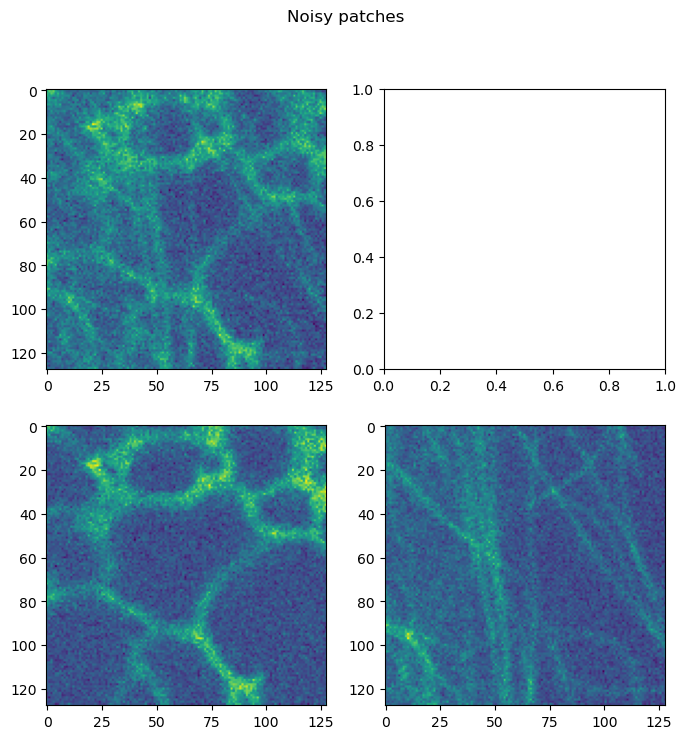

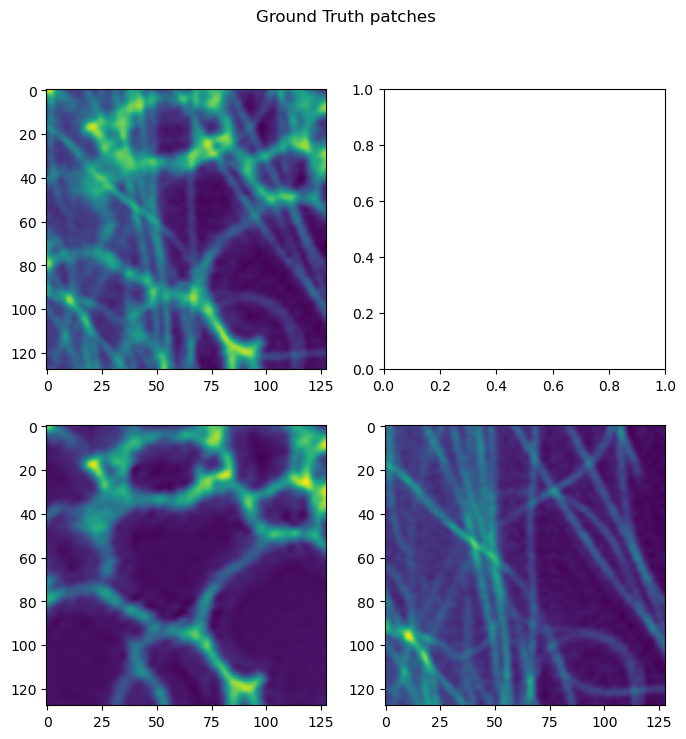

In [24]:
# Print input (first row) and target (second row) of the val_dset
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
gt_inp_tmp, gt_tar_tmp, *_ = highsnr_val_dset[idx]

# Noisy
ncols = len(tar_tmp)
nrows = 2
_, ax = plt.subplots(figsize=(4*ncols,4*nrows), ncols=ncols, nrows=nrows)
plt.suptitle("Noisy patches")
for i in range(min(ncols, len(inp_tmp))):
    ax[0,i].imshow(inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(tar_tmp[channel_id])
    
# Ground truth
ncols = len(gt_tar_tmp)
_, ax = plt.subplots(figsize=(4*ncols,4*nrows), ncols=ncols, nrows=nrows)
plt.suptitle("Ground Truth patches")
for i in range(min(ncols, len(gt_inp_tmp))):
    ax[0,i].imshow(gt_inp_tmp[i])

for channel_id in range(ncols):
    ax[1,channel_id].imshow(gt_tar_tmp[channel_id])

In [25]:
if data_t_list is not None:
    val_dset.reduce_data(t_list=data_t_list)

In [26]:
def get_full_input_frame(idx, dset):
    img_tuples, noise_tuples = dset._load_img(idx)
    if len(noise_tuples) > 0:
        factor = np.sqrt(2) if dset._input_is_sum else 1.0
        img_tuples = [x + noise_tuples[0] * factor for x in img_tuples]

    inp = 0
    for nch in img_tuples:
        inp += nch/len(img_tuples)
    h_start, w_start = dset._get_deterministic_hw(idx)
    return inp, h_start, w_start

In [27]:
index = np.random.randint(len(val_dset))
inp, tar = val_dset[index]
frame, h_start, w_start = get_full_input_frame(index, val_dset)
print(h_start, w_start)

768 0


#### Plot predictions against a baseline for specific indexes

In [28]:
def get_hwt_start(idx):
    h,w,t = val_dset.idx_manager.hwt_from_idx(idx, grid_size=64)
    print(h,w,t)
    pad = val_dset.per_side_overlap_pixelcount()
    h =  h - pad
    w = w - pad
    return h,w,t

def get_crop_from_fulldset_prediction(full_dset_pred, idx, patch_size=256):
    h,w,t = get_hwt_start(idx)
    return np.swapaxes(full_dset_pred[t,h:h+patch_size,w:w+patch_size].astype(np.float32)[None], 0, 3)[...,0]

if save_comparative_plots: # this is false...
    assert eval_datasplit_type == DataSplitType.Test
    # CCP vs Microtubules: 925, 659, 502
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_67.tif')
    hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M5_Sk0/pred_disentangle_2403_D23-M3-S0-L0_29.tif')

    # ER vs Microtubule 853, 859, 332
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_60.tif')

    #  ER vs CCP 327, 479, 637, 568
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G16_M3_Sk0/pred_disentangle_2402_D23-M3-S0-L0_59.tif')

    #  F-actin vs ER 797
    # hdn_usplitdata = load_tiff('/group/jug/ashesh/data/paper_stats/Test_PNone_G32_M10_Sk0/pred_disentangle_2403_D23-M3-S0-L0_15.tif')

    idx = 10 #np.random.randint(len(val_dset))
    patch_size = 500
    mmse_count = 50
    print(idx)
    show_for_one(
        idx, val_dset, 
        highsnr_val_dset, 
        model, 
        None, 
        mmse_count=mmse_count, 
        patch_size=patch_size, 
        baseline_preds=[
            get_crop_from_fulldset_prediction(hdn_usplitdata, idx).astype(np.float32),
        ],
        num_samples=0
    )

    plotsdir = get_plots_output_dir(
        ckpt_dir, 
        patch_size, 
        mmse_count=mmse_count
    )
    
    model_id = ckpt_dir.strip('/').split('/')[-1]
    fname = f'patch_comparison_{idx}_{model_id}.png'
    fpath = os.path.join(plotsdir, fname)
    plt.savefig(fpath, dpi=200, bbox_inches='tight')
    print(f'Saved to {fpath}')

#### Compute predictions and related metrics (PSNR) for the entire validation set

In [28]:
pred_tiled, rec_loss, logvar_tiled, patch_psnr_tuple, pred_std_tiled = get_dset_predictions(
  model, 
  val_dset,
  batch_size,
  num_workers=num_workers,
  mmse_count=mmse_count,
  model_type = model_type,
)
tmp = np.round([x.item() for x in patch_psnr_tuple],2)
print('Patch wise PSNR, as computed during training', tmp,np.mean(tmp))
print(f'Number of predicted tiles: {pred_tiled.shape[0]}, channels: {pred_tiled.shape[1]}, shape: {pred_tiled.shape[2:]}')
print(f'Reconstruction loss distrib: {np.quantile(rec_loss, [0,0.01,0.5, 0.9,0.99,0.999,1]).round(2)}')

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:09<00:00,  1.20s/it]

Patch wise PSNR, as computed during training [25.23 24.61] 24.92
Number of predicted tiles: 245, channels: 2, shape: (128, 128)
Reconstruction loss distrib: [10.04 10.05 10.16 10.22 10.23 10.24 10.24]


In [30]:
# Print tiles in which the logvar is very low
idx_list = np.where(logvar_tiled.squeeze() < -6)[0]
if len(idx_list) > 0:
    plt.imshow(val_dset[idx_list[0]][1][1])

Get full image predictions by stitching the predicted tiles

In [31]:
if pred_tiled.shape[-1] != val_dset.get_img_sz():
    pad = (val_dset.get_img_sz() - pred_tiled.shape[-1] )//2
    pred_tiled = np.pad(pred_tiled, ((0,0),(0,0),(pad,pad),(pad,pad)))

# Stitch tiled predictions
pred = stitch_predictions(
    pred_tiled, 
    val_dset, 
    smoothening_pixelcount=0
)

# Stitch predicted tiled logvar
if len(np.unique(logvar_tiled)) == 1:
    logvar = None
else:
    logvar = stitch_predictions(logvar_tiled, val_dset, smoothening_pixelcount=0)

# Stitch the std of the predictions (i.e., std computed on the mmse_count predictions)
pred_std = stitch_predictions(pred_std_tiled, val_dset, smoothening_pixelcount=0)

In [32]:
if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
    pred = pred[...,:len(config.data.target_idx_list)]
    pred_std = pred_std[...,:len(config.data.target_idx_list)]

Ignore (and remove) the pixels which are present in the last few rows and columns (since not multiples of patch_size)
1. They don't come in the batches. So, in prediction, they are simply zeros. So they are being are ignored right now. 
2. For the border pixels which are on the top and the left, overlapping yields worse performance. This is becuase, there is nothing to overlap on one side. So, they are essentially zero padded. This makes the performance worse. 

In [33]:
def get_ignored_pixels():
    ignored_pixels = 1
    while(pred[0, -ignored_pixels:, -ignored_pixels:,].std() == 0):
        ignored_pixels+=1
    ignored_pixels-=1
    print(f'In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.')
    return ignored_pixels

actual_ignored_pixels = get_ignored_pixels()

In (5, 1004, 1004, 2), last 108 many rows and columns are all zero.


In [34]:
if config.data.data_type in [
    DataType.OptiMEM100_014,
    DataType.SemiSupBloodVesselsEMBL, 
    DataType.Pavia2VanillaSplitting,
    DataType.ExpansionMicroscopyMitoTub,
    DataType.ShroffMitoEr,
    DataType.HTIba1Ki67
]:
    ignored_last_pixels = 32 
elif config.data.data_type == DataType.BioSR_MRC:
    ignored_last_pixels = 44
    if val_dset.get_img_sz() == 128:
        ignored_last_pixels = 108
elif config.data.data_type == DataType.NicolaData:
    ignored_last_pixels = 8
else:
    ignored_last_pixels = 0

ignore_first_pixels = 0
# ignored_last_pixels = 160
assert actual_ignored_pixels <= ignored_last_pixels, f'Set ignored_last_pixels={actual_ignored_pixels}'
print(ignored_last_pixels)

108


In [35]:
tar = val_dset._data
if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
    tar = tar[...,config.data.target_idx_list]

def ignore_pixels(arr, patch_size):
    if arr.shape[2] % patch_size:
        if ignore_first_pixels:
            arr = arr[:,ignore_first_pixels:,ignore_first_pixels:]
        if ignored_last_pixels:
            arr = arr[:,:-ignored_last_pixels,:-ignored_last_pixels]

    return arr

pred = ignore_pixels(pred, val_dset.get_img_sz())
tar = ignore_pixels(tar, val_dset.get_img_sz())
if pred_std is not None:
    pred_std = ignore_pixels(pred_std, val_dset.get_img_sz())
    
print(pred.shape)

(5, 896, 896, 2)


#### Perform Calibration

In [36]:
sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean['target']
    sep_std = sep_std['target']

if isinstance(sep_mean, int):
    pass
else:
    sep_mean = sep_mean.squeeze()[None,None,None]
    sep_std = sep_std.squeeze()[None,None,None]
    sep_mean = sep_mean.cpu().numpy() 
    sep_std = sep_std.cpu().numpy()

tar_normalized = (tar - sep_mean)/ sep_std

# Check if normalization is correct (i.e., not already applied on tar)
print(f"Channelwise means: tar -> {tar.mean(axis=(0,1,2))}, normalized -> {tar_normalized.mean(axis=(0,1,2))}")

Channelwise means: tar -> [6659.99033402 8694.15955835], normalized -> [0.06550117 0.39939846]


Plot RMV vs. RMSE without Calibration

/localscratch/miniforge3/envs/train_lvae/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localscratch/miniforge3/envs/train_lvae/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


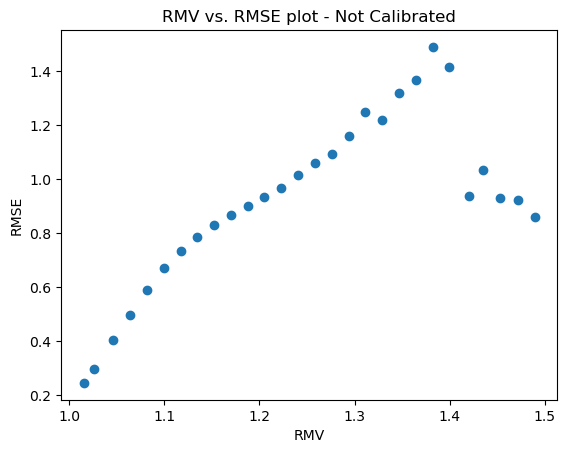

In [37]:
# NOTE: Recall the `pred_std` here is the pixel-wise std of the mmse_count many predictions
if enable_calibration:
    calib = Calibration(
        num_bins=30, 
        mode='pixelwise'
    )
    native_stats = calib.compute_stats(
        pred=pred, 
        pred_logvar=pred_std, 
        target=tar_normalized
    )
    count = np.array(native_stats[0]['bin_count'])
    count = count / count.sum()
    # print(count.cumsum()[:-1])
    plt.plot(native_stats[0]['rmv'][1:-1], native_stats[0]['rmse'][1:-1], 'o')
    plt.title("RMV vs. RMSE plot - Not Calibrated")
    plt.xlabel('RMV'), plt.ylabel('RMSE')

Observe that the plot is far from resembling y = x!

In [38]:
def get_calibration_fnames(ckpt_dir):
    tokens = ckpt_dir.strip('/').split('/')
    modelid = int(tokens[-1])
    model_specs = tokens[-2].replace('-','')
    monthyear = tokens[-3]
    fname_factor = f'calibration_factor_{monthyear}_{model_specs}_{modelid}.npy'
    fname_stats = f'calibration_stats_{monthyear}_{model_specs}_{modelid}.pkl.npy'
    return {'stats': fname_stats, 'factor': fname_factor}

def get_calibration_factor_fname(ckpt_dir):
    return get_calibration_fnames(ckpt_dir)['factor']

def get_calibration_stats_fname(ckpt_dir):
    return get_calibration_fnames(ckpt_dir)['stats']

/group/jug/federico/careamics_training/training/plots/patch_128_mmse_10


nll: 0.8230950236320496 scalar: 13.817364692687988: 100%|██████████| 500/500 [00:11<00:00, 45.29it/s]
nll: 0.8581922650337219 scalar: 11.406150817871094: 100%|██████████| 500/500 [00:10<00:00, 45.50it/s]


3.7171715984990508 3.3772993379135188
Saved calibration factor fitted on validation set to /group/jug/federico/careamics_training/training/plots/patch_128_mmse_10/calibration_factor_2406_LVAE_denoiSplit_45.npy


/localscratch/miniforge3/envs/train_lvae/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


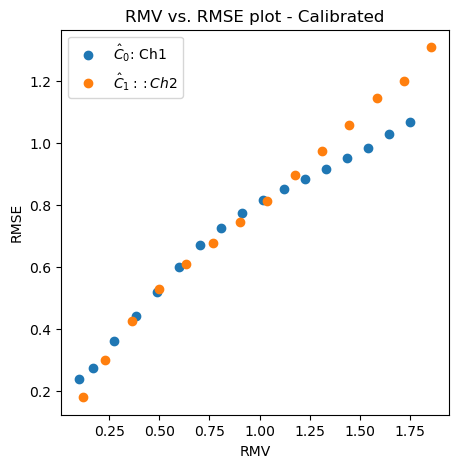

In [39]:
if enable_calibration:
    inp, _ = val_dset[0]
    plotsdir = get_plots_output_dir(OUT_ROOT, inp.shape[1], mmse_count=mmse_count)
    fname = get_calibration_factor_fname(ckpt_dir)
    factor_fpath = os.path.join(plotsdir, fname)
    
    # Compute calibration factors
    if eval_datasplit_type == DataSplitType.Val:
        # Compute calibration factors for the channels
        calib_factor0 = get_calibrated_factor_for_stdev(pred[...,0], np.log(pred_std[...,0]**2), tar_normalized[...,0], batch_size=8, lr=0.1)
        calib_factor1 = get_calibrated_factor_for_stdev(pred[...,1], np.log(pred_std[...,1]**2), tar_normalized[...,1], batch_size=8, lr=0.1)
        print(calib_factor0, calib_factor1)
        calib_factor = np.array([calib_factor0, calib_factor1]).reshape(1,1,1,2)
        np.save(factor_fpath, calib_factor)
        print(f'Saved calibration factor fitted on validation set to {factor_fpath}')

    # Use pre-computed calibration factor
    elif eval_datasplit_type == DataSplitType.Test:
        print('Loading the calibration factor from the file', factor_fpath)
        calib_factor = np.load(factor_fpath)

    # Given the calibration factor, plot RMV vs. RMSE
    calib = Calibration(num_bins=30, mode='pixelwise')
    pred_logvar = 2* np.log(pred_std * calib_factor)
    stats = calib.compute_stats(
        pred,
        pred_logvar, 
        tar_normalized
    )
    _,ax = plt.subplots(figsize=(5,5))
    plt.title("RMV vs. RMSE plot - Calibrated")
    plot_calibration(ax, stats)

if eval_datasplit_type == DataSplitType.Test:
    stats_fpath = os.path.join(plotsdir, get_calibration_stats_fname(ckpt_dir))
    np.save(stats_fpath, stats)
    print('Saved stats of Test set to ', stats_fpath)

A fancier Calibration Plot with multiple calibration factors:

In [40]:
def get_last_index(bin_count, quantile):
    cumsum = np.cumsum(bin_count)
    normalized_cumsum = cumsum / cumsum[-1]
    for i in range(1, len(normalized_cumsum)):
        if normalized_cumsum[-i] < quantile:
            return i - 1
    return None


def get_first_index(bin_count, quantile):
    cumsum = np.cumsum(bin_count)
    normalized_cumsum = cumsum / cumsum[-1]
    for i in range(len(normalized_cumsum)):
        if normalized_cumsum[i] > quantile:
            return i
    return None

In [41]:
try:
    calib_factors = [
        np.load(os.path.join('/path/to/calibration/factors/dir/', fpath), allow_pickle=True) 
        for fpath in [
            'calibration_stats_1.pkl.npy',
            'calibration_stats_2.pkl.npy',
            'calibration_stats_3.pkl.npy', 
        ]
    ]
    labels = ['w=0.5', 'w=0.9', 'w=1']
except FileNotFoundError:
    print('Calibration factors not found. Skipping the plot.')
    calib_factors = []

if len(calib_factors) > 0:
    _,ax = plt.subplots(figsize=(5,2.5))
    for i, calibration_stats in enumerate(calib_factors):
        first_idx = get_first_index(calibration_stats[()][0]['bin_count'], 0.0001)
        last_idx = get_last_index(calibration_stats[()][0]['bin_count'], 0.9999)
        ax.plot(
            calibration_stats[()][0]['rmv'][first_idx:-last_idx],
            calibration_stats[()][0]['rmse'][first_idx:-last_idx],
            '-+',
            label=labels[i]
        )

    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    ax.plot(np.arange(0,1.5, 0.01), np.arange(0,1.5, 0.01), 'k--')
    ax.set_facecolor('xkcd:light grey')
    plt.legend(loc='lower right')
    # plt.xlim(0,3)
    # plt.ylim(0,1.25)
    plt.xlabel('RMV')
    plt.ylabel('RMSE')
    ax.set_axisbelow(True)


    plotsdir = get_plots_output_dir(ckpt_dir, 0, mmse_count=0)
    model_id = ckpt_dir.strip('/').split('/')[-1]
    fname = f'calibration_plot_{model_id}.png'
    fpath = os.path.join(plotsdir, fname)
    # plt.savefig(fpath, dpi=200, bbox_inches='tight')
    print(f'Saved to {fpath}')


Calibration factors not found. Skipping the plot.


#### Visually compare Targets and Predictions

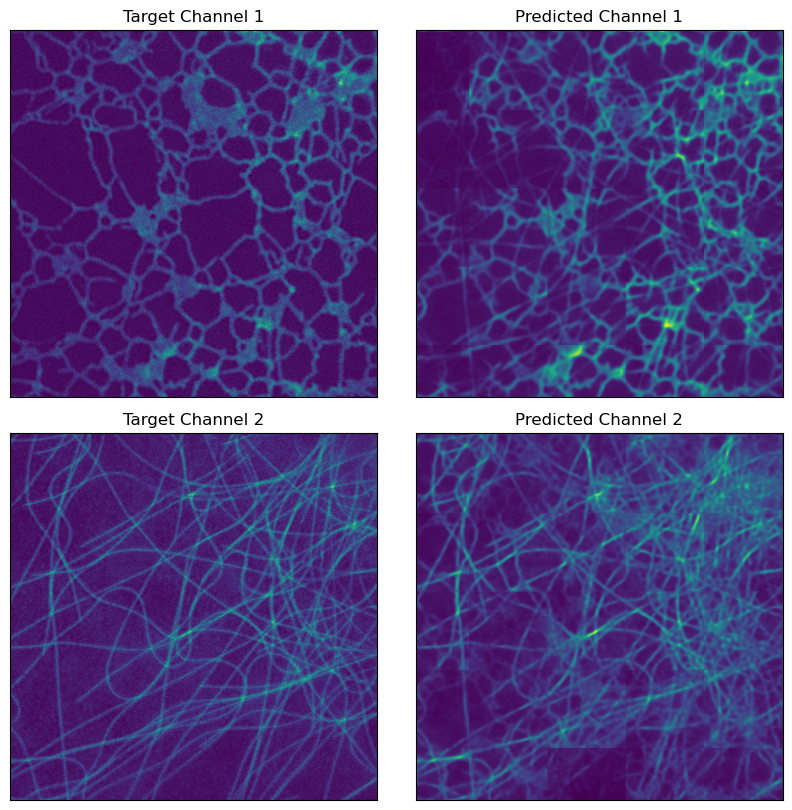

In [42]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = tar.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5, 2*5), nrows=2, ncols=ncols)
img_idx = np.random.randint(len(tar))
sz = 600
hs = np.random.randint(tar.shape[1] - sz)
ws = np.random.randint(tar.shape[2] - sz)
for i in range(ncols):
    ax[i,0].set_title(f'Target Channel {i+1}')
    ax[i,0].imshow(tar[0, hs:hs+sz, ws:ws+sz, i])
    ax[i,1].set_title(f'Predicted Channel {i+1}')
    ax[i,1].imshow(pred[0, hs:hs+sz, ws:ws+sz, i])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
clean_ax(ax)

0


/home/federico.carrara/Documents/projects/careamics/src/careamics/models/lvae/eval_utils.py:376: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


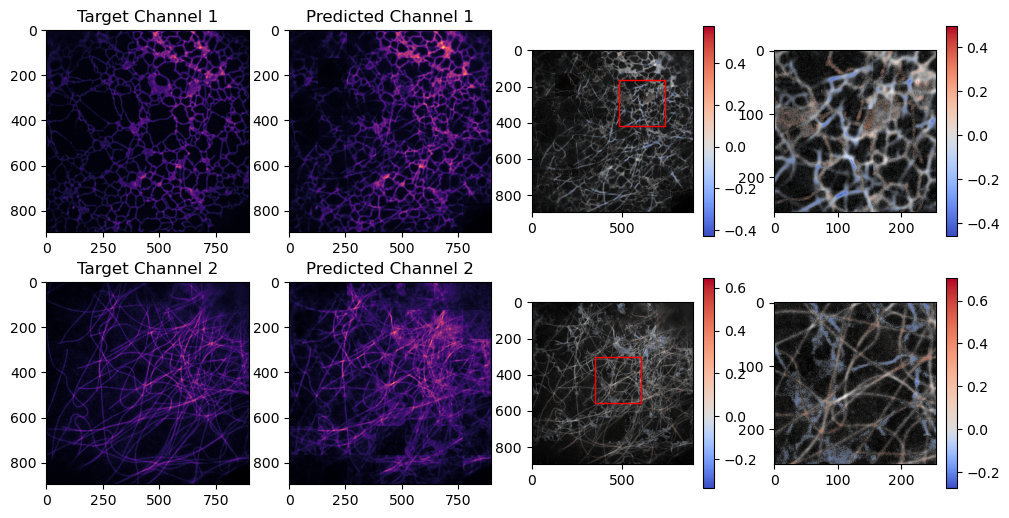

In [44]:
nrows = pred.shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(pred))
print(idx)
for ch_id in range(nrows):
    ax[ch_id,0].set_title(f'Target Channel {ch_id+1}')
    ax[ch_id,0].imshow(tar_normalized[idx,..., ch_id], cmap='magma')
    ax[ch_id,1].set_title(f'Predicted Channel {ch_id+1}')
    ax[ch_id,1].imshow(pred[idx,:,:,ch_id], cmap='magma')
    plot_error(
        tar_normalized[idx,...,ch_id], 
        pred[idx,:,:,ch_id], 
        cmap = matplotlib.cm.coolwarm, 
        ax = ax[ch_id,2], 
        max_val = None
    )

    cropsz = 256
    h_s = np.random.randint(0, tar_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, tar_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        tar_normalized[idx,h_s:h_e,w_s:w_e, ch_id], 
        pred[idx,h_s:h_e,w_s:w_e,ch_id], 
        cmap = matplotlib.cm.coolwarm, 
        ax = ax[ch_id,3], 
        max_val = None
    )

    # Add rectangle to the region
    rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
    ax[ch_id,2].add_patch(rect)


#### Compute metrics between predicted data and high-SNR (ground truth) data

Prepare data:

In [45]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
pred_unnorm = []
for i in range(pred.shape[-1]):
    if sep_std.shape[-1]==1:
        temp_pred_unnorm = pred[...,i]*sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = pred[...,i]*sep_std[...,i] + sep_mean[...,i]
    pred_unnorm.append(temp_pred_unnorm)

In [47]:
# Get & process high-SNR data from previously loaded dataset
highres_data = highsnr_val_dset._data
if highres_data is not None:
    highres_data = ignore_pixels(highres_data, highsnr_val_dset.get_img_sz()).copy()
    if data_t_list is not None:
        highres_data = highres_data[data_t_list].copy()
    
    if 'target_idx_list' in config.data and config.data.target_idx_list is not None:
        highres_data = highres_data[...,config.data.target_idx_list]

Compute metrics:

In [53]:
if highres_data is not None:
    print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
    psnr_list = [avg_range_inv_psnr(highres_data[...,k], pred_unnorm[k]) for k in range(len(pred_unnorm))]
    tar_tmp = (highres_data - sep_mean) /sep_std
    # tar0_tmp = (highres_data[...,0] - sep_mean[...,0]) /sep_std[...,0]
    ssim_list = compute_multiscale_ssim(tar_tmp, pred)
    # ssim1_hres_mean, ssim1_hres_std = avg_ssim(highres_data[...,0], pred_unnorm[0])
    # ssim2_hres_mean, ssim2_hres_std = avg_ssim(highres_data[...,1], pred_unnorm[1])
    print('PSNR on Highres', ' '.join([str(x) for x in psnr_list]))
    print('SSIM on Highres', ' '.join([str(np.round(x,3)) for x in ssim_list]))

Val_PNone_G32_M10_Sk108
PSNR on Highres 26.92 26.21
SSIM on Highres 0.847 0.793


In [54]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(pred.shape[-1]):
    rmse =np.sqrt(((pred[...,ch_id] - tar_normalized[...,ch_id])**2).reshape(len(pred),-1).mean(axis=1))
    rmse_arr.append(rmse)
    psnr = avg_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy()) 
    rinv_psnr = avg_range_inv_psnr(tar_normalized[...,ch_id].copy(), pred[...,ch_id].copy())
    ssim_mean, ssim_std = avg_ssim(tar[...,ch_id], pred_unnorm[ch_id])
    psnr_arr.append(psnr)
    rinv_psnr_arr.append(rinv_psnr)
    ssim_arr.append((ssim_mean,ssim_std))

In [58]:
print(f'{DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}')
print('Rec Loss: ', np.round(rec_loss.mean(),3) )
print('RMSE: ', ' <--> '.join([str(np.mean(x).round(3)) for x in rmse_arr]))
print('PSNR: ', ' <--> '.join([str(x) for x in psnr_arr]))
print('RangeInvPSNR: ',' <--> '.join([str(x) for x in rinv_psnr_arr]))
print('SSIM: ',' <--> '.join([f'{round(x,3)}±{round(y,4)}' for (x,y) in ssim_arr]))
print()

Val_PNone_G32_M10_Sk108
Rec Loss:  10.15
RMSE:  0.491 <--> 0.565
PSNR:  25.93 <--> 25.21
RangeInvPSNR:  26.15 <--> 25.3
SSIM:  0.584±0.0381 <--> 0.499±0.0552



#### Other evaluations

##### To save to tiff file.

In [ ]:
# ch1_pred_unnorm = pred[...,0]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy()
# input_pred_unnorm = pred[...,2]*sep_std[...,0].cpu().numpy() + sep_mean[...,0].cpu().numpy()
# ch2_pred_unnorm = input_pred_unnorm - ch1_pred_unnorm
# ch2_pred_unnorm = pred[...,1]*sep_std[...,1].cpu().numpy() + sep_mean[...,1].cpu().numpy() #ch2_pred_unnorm - ch2_pred_unnorm.min()

# ch1_pred_unnorm = ch1_pred_unnorm.astype(np.int32)
# input_pred_unnorm = input_pred_unnorm.astype(np.int32)
# ch2_pred_unnorm = ch2_pred_unnorm.astype(np.int32)

# data = np.concatenate([val_dset._data[:,:480,:480], ch1_pred_unnorm[...,None],
# ch2_pred_unnorm[...,None], input_pred_unnorm[...,None]],
# axis=-1)

# import tifffile
# tifffile.imwrite("prediction2.tif", 
# np.swapaxes(data[:,None],1,4)[...,0].astype(np.uint16),
# imagej=True, 
# #  metadata={ 'axes': 'ZYXC'}, 
#  )

In [ ]:
_, ax  = plt.subplots(figsize=(10,5),ncols=2)
ax[0].imshow(highsnr_val_dset._data[0,:200,:200,0])
ax[1].imshow(val_dset._data[0,:200,:200,0])
highsnr_val_dset._data.shape

In [ ]:
break here

In [ ]:
# from disentangle.analysis.paper_plots import show_for_one
# # show_for_one(np.random.randint(len(val_dset)), mmse_count=50, patch_size=256)
# # show_for_one(899, mmse_count=50, patch_size=256)
# # show_for_one(51, mmse_count=50, patch_size=256)
# # # show_for_one(352, mmse_count=50, patch_size=256)
# # show_for_one(872, mmse_count=50, patch_size=256)
# # show_for_one(552, mmse_count=50, patch_size=256)
# 656, 327, 612, 490
# 51, 899, 352, 872, 552 ER vs Microtubules (144)
# 716, 599, 173 CCP vs Microtubules (145)
#  703, 189, 423 ER vs CCP (143)
# 772, 694, 237. Adverse:630 F-actin vs Er 
idx = 716
patch_size = 256
mmse_count = 50
print(idx)
# fname = f'patch_comparison_{idx}.png'
# show_for_one(idx, val_dset, highsnr_val_dset, model, None, mmse_count=mmse_count, patch_size=patch_size, baseline_preds=[
#     get_crop_from_fulldset_prediction(hdn_usplitdata, idx).astype(np.float32),
# ], num_samples=0)

show_for_one(idx, val_dset, highsnr_val_dset, model, stats, mmse_count=mmse_count, patch_size=patch_size, num_samples=2)

plotsdir = get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=mmse_count)
model_id = ckpt_dir.strip('/').split('/')[-1]
fname = f'sampling_figure_{idx}_{model_id}.png'
fpath = os.path.join(plotsdir, fname)
plt.savefig(fpath, dpi=200, bbox_inches='tight')
print(f'Saved to {fpath}')

In [ ]:
break here

##### Creating tiff file

In [ ]:
from disentangle.analysis.paper_plots import get_plotoutput_dir, get_predictions
patch_size = 256
mmse_count = 50
idx_list = [51, 899, 352, 872, 552, 841] # Tub vs MT


plotsdir = get_plotoutput_dir(ckpt_dir, patch_size, mmse_count=mmse_count)
for idx in idx_list:
    inp, tar, tar_hsnr, recon_img_list = get_predictions(idx, val_dset, model, mmse_count=mmse_count, patch_size=patch_size)
    highsnr_val_dset.set_img_sz(patch_size, 64)
    highsnr_val_dset.disable_noise()
    _, tar_hsnr = highsnr_val_dset[idx]
    plotfpath = os.path.join(plotsdir, f'{idx}.npy')
    np.save(plotfpath, {'inp':inp, 'tar':tar, 'tar_hsnr':tar_hsnr, 'recon_img_list':recon_img_list})
    print(f'Generated {plotfpath}')

In [ ]:
ddict = np.load('/group/jug/ashesh/data/paper_figures/patch_256_mmse_50/2402-D16M3S0-150/841.npy', allow_pickle=True)
plt.imshow(ddict[()]['inp'][0,0].cpu().numpy())

In [ ]:
plot_crops(ddict[()]['inp'], ddict[()]['tar'], ddict[()]['tar_hsnr'], ddict[()]['recon_img_list'])


In [ ]:
from skimage.io import imsave
import numpy as np
pred_unnorm = np.concatenate([ch1_pred_unnorm[...,None],
                              ch2_pred_unnorm[...,None]],
                              axis=-1)
for ch_idx in [0,1]:
    tif_fname = f'{fname_prefix}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_last_pixels}_C{ch_idx}.tif'
    tif_fpath=os.path.join('paper_tifs',tif_fname)
    if config.data.data_type in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        output = np.concatenate([
                            pred_unnorm[None,:50,...,ch_idx],tar[None,:50,...,ch_idx],
        ],axis=0)
    else:
        output = np.concatenate([
                                pred_unnorm[:1,...,ch_idx],tar[:1,...,ch_idx],
        ],axis=0)
    imsave(tif_fpath,output,plugin='tifffile')
    print(tif_fpath)

In [ ]:
! ls -lhrt paper_tifs/2211-D8M3S0-*

In [ ]:
# !ls paper_tifs/2211-D3M3S0-0_P64_G*

In [ ]:
idx = np.random.randint(len(val_dset))
inp, tar = val_dset[idx]

In [ ]:
if len(inp) > 1:
    _,ax = plt.subplots(figsize=(10,2.5),ncols=4)
    ax[0].imshow(inp[0])
    ax[1].imshow(inp[1])
    ax[2].imshow(inp[2])
    ax[3].imshow(inp[3])

In [ ]:
tar_unnorm.shape

In [ ]:
# _,ax = plt.subplots(figsize=(10,10))
# tmp_data =tar_unnorm[idx,:,:,1]
# q = np.quantile(tmp_data,0.95)
# tmp_data[tmp_data >q] = q
# plt.imshow(tmp_data)

In [ ]:
pred_unnorm.min()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,20),ncols=2,nrows=2)
ax[0,0].set_title('Channel 1',size=20)
ax[0,1].set_title('Channel 2',size=20)
ax[0,0].set_ylabel('Target',size=20)
ax[1,0].set_ylabel('Predictions',size=20)
ax[0,0].imshow(tar_unnorm[idx,:,:,0])
ax[0,1].imshow(tar_unnorm[idx,:,:,1])
ax[1,0].imshow(pred_unnorm[idx,:,:,0])
ax[1,1].imshow(pred_unnorm[idx,:,:,1])

In [ ]:
idx =  0#np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)
sz = 400
ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1000+sz,400:400+sz], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1000+sz,400:400+sz], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,0],vmax=126,vmin=88)
ax[1,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,0], vmax=126,vmin=88)

ax[2,0].imshow(tar_unnorm[idx, 1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)
ax[2,1].imshow(pred_unnorm[idx,1000:1000+sz,400:400+sz,1],vmax=126,vmin=78)

In [ ]:
tar_unnorm[idx, 1000:1500,400:900,0].std()

In [ ]:
pred_unnorm[idx,1000:1500,400:900,0].std()

In [ ]:
idx =  np.random.randint(len(tar_unnorm))
print(idx)
_,ax = plt.subplots(figsize=(20,30),ncols=2,nrows=3)
ax[0,0].set_title('Target',size=20)
ax[0,1].set_title('Prediction',size=20)
ax[0,0].set_ylabel('Mixed Input',size=20)
ax[1,0].set_ylabel('Channel 1',size=20)
ax[2,0].set_ylabel('Channel 2',size=20)

ax[0,0].imshow(np.mean(tar_unnorm[idx, 1000:1500,400:900], axis=2))
ax[0,1].imshow(np.mean(pred_unnorm[idx,1000:1500,400:900], axis=2))

ax[1,0].imshow(tar_unnorm[idx, 1000:1500,400:900,0])
ax[1,1].imshow(pred_unnorm[idx,1000:1500,400:900,0])

ax[2,0].imshow(tar_unnorm[idx, 1000:1500,400:900,1])
ax[2,1].imshow(pred_unnorm[idx,1000:1500,400:900,1])

In [ ]:
break here

##### Comparing PSNR with high res data. 

In [ ]:
from disentangle.core.data_split_type import  get_datasplit_tuples

In [ ]:
if eval_datasplit_type == DataSplitType.Val:
    N = len(pred1)/config.training.val_fraction
elif eval_datasplit_type == DataSplitType.Test:
    N = len(pred1)/config.training.test_fraction
train_idx,val_idx,test_idx = get_datasplit_tuples(config.training.val_fraction,config.training.test_fraction,N,
                                          starting_train=False)

In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
highres_actin = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')[...,None]
highres_mito = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/mito-60x-noise2-highsnr.tif')[...,None]

if eval_datasplit_type == DataSplitType.Val:
    highres_data = np.concatenate([highres_actin[val_idx[0]:val_idx[1]],
                                   highres_mito[val_idx[0]:val_idx[1]]],
                                  axis=-1).astype(np.float32)
elif eval_datasplit_type == DataSplitType.Test:
    highres_data = np.concatenate([highres_actin[test_idx[0]:test_idx[1]],
                                   highres_mito[test_idx[0]:test_idx[1]]],
                                  axis=-1).astype(np.float32)

In [ ]:
thresh = np.quantile(highres_data,config.data.clip_percentile)
highres_data[highres_data > thresh]=thresh
    

In [ ]:
_,ax = plt.subplots(figsize=(8,8),ncols=2,nrows=2)
ax[0,0].imshow(tar_unnorm[5,...,0])
ax[0,1].imshow(highres_data[5,...,0])
ax[1,0].imshow(tar_unnorm[8,...,1])
ax[1,1].imshow(highres_data[8,...,1])


In [ ]:
print('PSNR with HighRes', avg_psnr(highres_data[...,0], pred1),avg_psnr(highres_data[...,1], pred2))
print('RangeInvPSNR with HighRes', avg_range_inv_psnr(highres_data[...,0], pred1), 
      avg_range_inv_psnr(highres_data[...,1], pred2))


In [ ]:
# RangeInvPSNR with HighRes 16.82 18.33


In [ ]:
tar_1_tmp.dtype

In [ ]:
from disentangle.core.psnr import fix_range, zero_mean
def fix_range_with_highresdata(pred,tar):
    pred_1_tmp = torch.Tensor(pred.reshape(len(pred),-1))
    tar_1_tmp = torch.Tensor(tar.reshape(len(tar),-1))
    pred_1_tmp = zero_mean(pred_1_tmp)
    tar_1_tmp = zero_mean(tar_1_tmp)
#     import pdb;pdb.set_trace()
    tar_1_tmp = tar_1_tmp / torch.std(tar_1_tmp, dim=1, keepdim=True)
    
    pred_1_tmp = fix_range(tar_1_tmp,pred_1_tmp)
    pred_1_tmp = pred_1_tmp.reshape_as(torch.Tensor(pred))
    tar_1_tmp = tar_1_tmp.reshape_as(torch.Tensor(pred))
    return pred_1_tmp, tar_1_tmp

In [ ]:
pred1_tmp, tar1_tmp = fix_range_with_highresdata(pred1, highres_data[...,0])
pred2_tmp, tar2_tmp = fix_range_with_highresdata(pred2, highres_data[...,1])

In [ ]:
ssim1_mean, ssim1_std = avg_ssim(tar1_tmp.numpy(), pred1_tmp.numpy())
ssim2_mean, ssim2_std = avg_ssim(tar2_tmp.numpy(), pred2_tmp.numpy())
print(ssim1_mean, ssim2_mean)

In [ ]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(pred_1_tmp[0])
ax[1].imshow(tar_1_tmp[0])


In [ ]:
break here.

##### Inspecting the performance on grid boundaries.


In [ ]:
from disentangle.analysis.stitch_prediction import stitched_prediction_mask


skip_boundary_pixel_count = 0
for sk_c in [1,16,32,48,56]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                skip_boundary_pixel_count, 
                                sk_c)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipCentral', sk_c,
          psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

##### Inspecting the performance on central regions

In [ ]:
skip_central_pixel_count = 0

for sk_b in [1,8,16,20,24]:
    mask = stitched_prediction_mask(val_dset, 
                                (val_dset._img_sz,val_dset._img_sz), 
                                sk_b, 
                                skip_central_pixel_count)
    mask = ignore_pixels(mask)
    psnr1, psnr2 = compute_masked_psnr(mask, tar1,tar2,pred1,pred2)
    print(f'[Pad:{val_dset.per_side_overlap_pixelcount()}] SkipBoundary', sk_b, psnr1,psnr2)

In [ ]:
plt.imshow(mask[0,:,:,0])

In [ ]:
# for w in range(2,202,25):
#     print(f'RangeInvPSNR but skipping {w}', avg_range_inv_psnr(np.copy(tar1[:,w:-w,w:-w]), 
#                                                                np.copy(pred1[:,w:-w,w:-w])),
    
#                                             avg_range_inv_psnr(np.copy(tar2[:,w:-w,w:-w]), 
#                                                                np.copy(pred2[:,w:-w,w:-w]).copy()))

In [ ]:
h = 1200
w = 1200
sz = 512
x = tar_unnorm[:1,h:h+sz,w:w+sz].mean(axis=3)

In [ ]:
p_count = 32
y1 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]))
y2 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), constant_values=237)
y3 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]), mode='linear_ramp', end_values=237)
y4 = np.pad(x,np.array([[0, 0], [p_count, p_count], [p_count, p_count]]),mode='reflect')


In [ ]:
np.quantile(x, [0,0.05, 0.1])

In [ ]:
_,ax = plt.subplots(figsize=(16,4),ncols=4)
ax[0].imshow(y1[0], )
ax[1].imshow(y2[0], )
ax[2].imshow(y3[0], )
ax[3].imshow(y4[0], )

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(tar_unnorm[-1,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(tar_unnorm[-1,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=2)
sns.histplot(pred_unnorm[0,:,:,0].reshape(-1,),ax=ax[0])
sns.histplot(pred_unnorm[0,:,:,1].reshape(-1,),ax=ax[1])

In [ ]:
import matplotlib.ticker as ticker
# import seaborn.apionly as sns

_,ax = plt.subplots(figsize=(20,4))
sns.histplot(tar_unnorm[-1,:,:].mean(axis=2).reshape(-1,))
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [ ]:
tar_unnorm[-1,:,:].shape

In [ ]:
# inp, tar = val_dset[11060]

In [ ]:
# _,ax = plt.subplots(figsize=(16,4),ncols=4)
# ax[0].imshow(inp[0])
# ax[1].imshow(inp[1])
# ax[2].imshow(inp[2])
# ax[3].imshow(inp[3])

In [ ]:
# _,ax = plt.subplots(figsize=(8,4),ncols=2)
# ax[0].imshow(tar[0])
# ax[1].imshow(tar[1])

##### Inspecting the difference in behaviour when different sized inputs are passed. 

In [ ]:
import seaborn as sns
def compute_centered_diff(big,small):
    pad = (big.shape[-1] - small.shape[-1])//2
#     import pdb;pdb.set_trace()
    return big[:,:,pad:-pad,pad:-pad] - small
 
old_img_sz = val_dset.get_img_sz()
val_dset.set_img_sz(128)
inp2, tar2 = val_dset[10000]
with torch.no_grad():
    bu_values2 = model.bottomup_pass(torch.Tensor(inp2[None]).cuda())

val_dset.set_img_sz(256)
inp3, tar3 = val_dset[10000]
with torch.no_grad():
    bu_values3 = model.bottomup_pass(torch.Tensor(inp3[None]).cuda())

diff = (bu_values2[0] - bu_values3[0][:,:,32:-32,32:-32]).cpu().numpy()
sns.histplot(diff.reshape(-1,))

##LOOKING AT bu_values
idx=1
diff = compute_centered_diff(bu_values3[idx],bu_values2[idx]).cpu().numpy()
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,0])

## Looking at the difference in prediction.
with torch.no_grad():
    out2,_ = model(torch.Tensor(inp2[None,]).cuda())
    out3,_ = model(torch.Tensor(inp3[None,]).cuda())
    img2 = get_img_from_forward_output(out3,model)
    img3 = get_img_from_forward_output(out2,model)
diff = compute_centered_diff(img2,img3)
_,ax =plt.subplots(figsize=(10,10))
sns.heatmap(diff[0,1].cpu().numpy())
val_dset.set_img_sz(old_img_sz)


In [ ]:
from disentangle.core.tiff_reader import load_tiff

In [ ]:
img = load_tiff('/home/ashesh.ashesh/data/ventura_gigascience/actin-60x-noise2-highsnr.tif')

In [ ]:
img.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img[0])
ax[1].imshow(img[1])
ax[2].imshow(img[2])
ax[3].imshow(img[3])

In [ ]:
img2 =load_tiff('/home/ashesh.ashesh/data/microscopy/OptiMEM100x014.tif')

In [ ]:
img2.shape

In [ ]:
_,ax = plt.subplots(figsize=(20,5),ncols=4)
ax[0].imshow(img2[0,...,0])
ax[1].imshow(img2[1,...,0])
ax[2].imshow(img2[2,...,0])
ax[3].imshow(img2[3,...,0])

###### 

In [ ]:
inp, tar = val_dset[0]

In [ ]:
inp.shape

In [ ]:
# _,ax = plt.subplots(figsize=(3,3))
plt.imshow(tar[0])

In [ ]:
plt.imshow(inp[0])

In [ ]:
(0.436+0.810)/2